In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/sj/dacon/cancer_transfer_prediction

/content/drive/MyDrive/sj/dacon/cancer_transfer_prediction


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from tensorflow.image import pad_to_bounding_box, resize, random_crop, random_flip_left_right
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D, concatenate, BatchNormalization, Activation

In [ ]:
def plot_learning_progress(train_history):
    hist = train_history.history
    x_arr = np.arange(len(hist['loss']))


    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x_arr, hist['loss'], 
            '-o', label='Train Loss')
    plt.plot(x_arr, hist['val_loss'],
            '--<', label='Validation Loss')
    plt.legend(fontsize=15)


    plt.subplot(1, 2, 2)
    plt.plot(x_arr, hist['accuracy'], 
            '-o', label='Train Accuracy.')
    plt.plot(x_arr, hist['val_accuracy'], 
            '--<', label='Validation Accuracy.')
    plt.legend(fontsize=15)
    plt.show()

In [ ]:
config = {
    'IMG_SIZE': 224,
    'EPOCHS':10,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':32,
    'SEED':41
}

In [ ]:
df = pd.read_csv("train.csv")
df.head()

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0


In [ ]:
df['암의 장경'] = round(df['암의 장경'].fillna(df['암의 장경'].mean()), 1)
df = df.fillna(0)
df.head()

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,0.0,0.00,0.0,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.00,0.0,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,18.4,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,0.0,0.00,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.00,0.0,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,0.0,8.0,1.0,2.0,1.0,5.44,0.0,0


In [ ]:
df = df.drop(["ID", "mask_path", "수술연월일"], axis=1)
df.head()

,img_path,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,./train_imgs/BC_01_0001.png,63,1,2,1,19.0,2.0,1.0,2.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,0.0,0.00,0.0,0
1,./train_imgs/BC_01_0002.png,51,1,1,1,22.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.00,0.0,1
2,./train_imgs/BC_01_0003.png,37,1,2,1,18.4,2.0,0.0,0.0,0.0,...,7.0,1.0,4.0,7.0,0.0,1.0,0.0,0.00,0.0,0
3,./train_imgs/BC_01_0004.png,54,1,2,1,0.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.00,0.0,0
4,./train_imgs/BC_01_0005.png,57,1,2,1,8.0,2.0,2.0,3.0,2.0,...,8.0,0.0,0.0,8.0,1.0,2.0,1.0,5.44,0.0,0


In [ ]:
numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ["img_path", "N_category"]
for col in df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

df.head()

,img_path,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,./train_imgs/BC_01_0001.png,0.558824,1,2,1,0.172727,2.0,1.0,2.0,2.0,...,1.000,1.0,0.111111,0.123711,0.0,1.0,0.0,0.000000,0.0,0
1,./train_imgs/BC_01_0002.png,0.382353,1,1,1,0.200000,3.0,3.0,3.0,3.0,...,0.000,0.0,0.000000,0.721649,0.0,0.0,0.0,0.000000,0.0,1
2,./train_imgs/BC_01_0003.png,0.176471,1,2,1,0.167273,2.0,0.0,0.0,0.0,...,0.875,1.0,0.074074,0.072165,0.0,1.0,0.0,0.000000,0.0,0
3,./train_imgs/BC_01_0004.png,0.426471,1,2,1,0.000000,3.0,3.0,3.0,3.0,...,0.000,0.0,0.000000,0.010309,1.0,3.0,0.0,0.000000,0.0,0
4,./train_imgs/BC_01_0005.png,0.470588,1,2,1,0.072727,2.0,2.0,3.0,2.0,...,1.000,0.0,0.000000,0.082474,1.0,2.0,1.0,0.057872,0.0,0


In [ ]:
df.shape

(1000, 25)

In [ ]:
df = df.sample(frac=1, random_state=config['SEED']).reset_index(drop=True)
df_train, df_valid = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8):]
df_train.shape, df_valid.shape

((800, 25), (200, 25))

In [ ]:
df_train["N_category"].value_counts().sort_index()

0    397
1    403
Name: N_category, dtype: int64

In [ ]:
def generator_train():
    for item in df_train.values:
        yield (item[0], item[1:-1], item[-1])

def generator_valid():
    for item in df_valid.values:
        yield (item[0], item[1:-1], item[-1])
    
dataset_train = tf.data.Dataset.from_generator(
    generator_train,
    (tf.string, tf.float32, tf.int32),
    ((), (23,), ())
    )

dataset_valid = tf.data.Dataset.from_generator(
    generator_valid,
    (tf.string, tf.float32, tf.int32),
    ((), (23,), ())
    )

def augmentation(image):
    h, w = image.shape[0], image.shape[1]
    size = h if h > w else w
    dst = pad_to_bounding_box(image, int((size-h)/2), int((size-w)/2), size, size)
    dst = resize(dst, size=(config['IMG_SIZE'], config['IMG_SIZE']))

    dst = random_flip_left_right(dst)
    dst = tf.cast(dst, tf.float32)
    dst /= 255

    return dst

def preprocessing(path, category, label):
    label = tf.one_hot(label, 2)
    bin = tf.io.read_file(path)
    image = tf.io.decode_png(bin, channels=3)
    image= tf.py_function(augmentation, [image], [tf.float32])
    image = tf.squeeze(image)
    return (image, category), label

dt = dataset_train.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dt = dt.batch(config['BATCH_SIZE']).prefetch(3)
dv = dataset_valid.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dv = dv.batch(config['BATCH_SIZE']).prefetch(3)

(224, 224, 3)
tf.Tensor(
[0.45588234 1.         2.         1.         0.24545455 3.
 3.         3.         3.         3.         2.         0.
 2.         0.         0.         0.         0.         0.
 0.         2.         0.         0.01212766 0.        ], shape=(23,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)


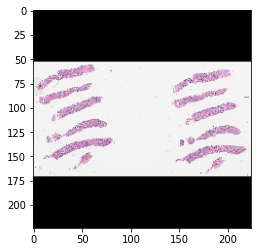

In [ ]:
for (image, clinical), label in dt.take(1):
    print(image[0].shape)
    print(clinical[0])
    print(label[0])
    plt.imshow(image[0])
    plt.show()

(224, 224, 3)
tf.Tensor(
[0.61764705 1.         1.         1.         0.3181818  2.
 3.         3.         2.         3.         0.         0.
 2.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.        ], shape=(23,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)


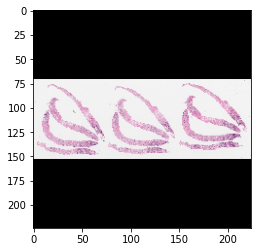

In [ ]:
for (image, clinical), label in dv.take(1):
    print(image[0].shape)
    print(clinical[0])
    print(label[0])
    plt.imshow(image[0])
    plt.show()

In [ ]:
def CustomDense(channels):
    model = tf.keras.models.Sequential([
        Dense(channels),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5)
    ])
    return model

class ImageFeature(tf.keras.Model):
    def __init__(self, freeze=False):
        super(ImageFeature, self).__init__()
        self.backbone = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3], weights='imagenet')
        if freeze:
            self.backbone.trainable = False
        self.flatten = GlobalAveragePooling2D()
        self.fc1 = CustomDense(1024)
        self.fc2 = CustomDense(512)
        self.fc3 = CustomDense(256)        

    def call(self, input):
        x = self.backbone(input)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

class TabularFeature(tf.keras.Model):
    def __init__(self):
        super(TabularFeature, self).__init__()
        self.fc1 = CustomDense(128)
        self.fc2 = CustomDense(256)        

    def call(self, input):
        x = self.fc1(input)
        x = self.fc2(x)
        return x

class Classification(tf.keras.Model):
    def __init__(self, n_class):
        super(Classification, self).__init__()
        self.ImageFeature = ImageFeature()
        self.TabularFeature = TabularFeature()
        self.fc1 = CustomDense(64)
        self.fc2 = CustomDense(16)
        self.cls = Dense(n_class, activation='softmax')

    def call(self, input):
        img_feature = self.ImageFeature(input[0])
        tabular_feature = self.TabularFeature(input[1])
        feature = concatenate([img_feature, tabular_feature], axis=-1)
        x = self.fc1(feature)
        x = self.fc2(x)
        output = self.cls(x)
        return output

In [ ]:
model = Classification(2)

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn, metric):
        import copy
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_metric = copy.deepcopy(metric)
        self.valid_metric = copy.deepcopy(metric)

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            logits = self.model(x)
            train_loss = self.loss_fn(y, logits)
        grads = tape.gradient(train_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_metric.update_state(y, logits)
        return train_loss

    @tf.function
    def valid_step(self, x, y):
        valid_logits = self.model(x)
        valid_loss = self.loss_fn(y, valid_logits)
        self.valid_metric.update_state(y, valid_logits)
        return valid_loss

    def train(self, train_dataset, valid_dataset, epochs=10, batch=32):
        import time
        from tqdm import tqdm

        best_score = 1
        best_model = None
        monitor = [1]
        history = {'acc': {'train': [], 'valid': []}, 'loss': {'train': [], 'valid': []}}

        train_max_iter = len(list(train_dataset))
        valid_max_iter = len(list(valid_dataset))
        print(f'train_max_iter:{train_max_iter}, valid_max_iter:{valid_max_iter}')

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            start_time = time.time()

            for x_batch_train, y_batch_train in tqdm(train_dataset, total=train_max_iter):
                train_loss = self.train_step(x_batch_train, y_batch_train)

            for x_batch_valid, y_batch_valid in tqdm(valid_dataset, total=valid_max_iter):
                valid_loss = self.valid_step(x_batch_valid, y_batch_valid)
            
            train_acc = self.train_metric.result()
            self.train_metric.reset_states()
            valid_acc = self.valid_metric.result()
            self.valid_metric.reset_states()
            history['acc']['train'].append(train_acc)
            history['acc']['valid'].append(valid_acc)
            history['loss']['train'].append(train_loss)
            history['loss']['valid'].append(valid_loss)

            print(f'time: {time.time() - start_time:.3f}, train_loss: {train_loss:.4f}, train_recall: {train_acc:.4f}, valid_loss: {valid_loss:.4f}, valid_recall: {valid_acc:.4f}')
            if best_score > valid_loss:
                best_score = valid_loss
                best_model = model
                print('best model saved')
                model.save('keras_models')
        
            if min(monitor) > valid_loss:
                monitor.clear()
            monitor.append(valid_loss)
            if len(monitor) == 10:
                print('earlystopping')
                break
        return history

In [ ]:
# jit_compile=False
trainer = Trainer(model=model,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=config['LEARNING_RATE']),
                  loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metric=tf.keras.metrics.Recall())
history = trainer.train(train_dataset=dt,
                        valid_dataset=dv,
                        epochs=config['EPOCHS'],
                        batch=config['BATCH_SIZE'])

train_max_iter:25, valid_max_iter:7

Epoch 1/10


100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


time: 88.645, train_loss: 0.6100, train_recall: 0.6388, valid_loss: 0.5655, valid_recall: 0.6950
best model saved



Epoch 2/10


100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


time: 48.844, train_loss: 0.5586, train_recall: 0.7075, valid_loss: 0.4346, valid_recall: 0.6900
best model saved



Epoch 3/10


100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


time: 48.546, train_loss: 0.5586, train_recall: 0.6888, valid_loss: 0.5474, valid_recall: 0.7350

Epoch 4/10


100%|██████████| 7/7 [00:10<00:00,  1.46s/it]


time: 48.177, train_loss: 0.5784, train_recall: 0.7312, valid_loss: 0.6364, valid_recall: 0.7050

Epoch 5/10


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


time: 48.748, train_loss: 0.6037, train_recall: 0.7325, valid_loss: 0.5625, valid_recall: 0.7400

Epoch 6/10


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


time: 49.024, train_loss: 0.6183, train_recall: 0.7550, valid_loss: 0.6621, valid_recall: 0.7100

Epoch 7/10


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


time: 49.113, train_loss: 0.5632, train_recall: 0.7513, valid_loss: 0.5660, valid_recall: 0.7400

Epoch 8/10


100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


time: 49.101, train_loss: 0.5522, train_recall: 0.7588, valid_loss: 0.5554, valid_recall: 0.7400

Epoch 9/10


100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


time: 48.398, train_loss: 0.5386, train_recall: 0.7575, valid_loss: 0.6133, valid_recall: 0.7500

Epoch 10/10


100%|██████████| 7/7 [00:09<00:00,  1.42s/it]

time: 48.493, train_loss: 0.5082, train_recall: 0.7588, valid_loss: 0.4511, valid_recall: 0.7450
